# 1. 导入库与环境配置

本节目标：

- 搭建项目运行环境
- 导入所有将使用的核心库
- 检测 GPU / CPU 运行设备
- 为后续实验做可复现性配置

本项目以“数字图像处理”为核心，因此本节主要导入：

- **图像处理库**：OpenCV、scikit-image
- **数据处理库**：numpy、pandas
- **可视化库**：matplotlib、seaborn
- **深度学习库（后面 CNN 会用）**：PyTorch 或 TensorFlow（二选一，这里使用 PyTorch）
- **系统库**：os、glob、pathlib

重点：图像在计算机中以矩阵形式表达，因此 numpy + cv2 是本项目的最基本依赖。

下面开始正式导库与环境检测。


PyTorch 版本: 2.7.1+cu118
CUDA 可用 ✓
GPU 名称: NVIDIA GeForce RTX 4060 Laptop GPU
当前计算设备: cuda
OpenCV 版本: 4.12.0


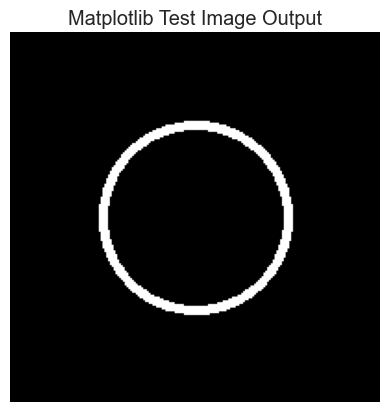

In [2]:
# ================================================
# Section 1 — 导入库与环境配置
# ================================================

# ----- 基础库 -----
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
matplotlib.rcParams['axes.unicode_minus'] = False

import os
import sys
import numpy as np
import pandas as pd

# ----- 图像处理库 -----
import cv2
from skimage import io, color, filters, feature

# ----- 可视化库 -----
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2)

# ----- 深度学习库（用于 CNN） -----
import torch
import torch.nn as nn
import torch.nn.functional as F

# ----- 实验可复现性 -----
import random

# 固定随机种子（保证每次结果一致）
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():          # 只有有 CUDA 才去设 CUDA 的种子
    torch.cuda.manual_seed_all(seed)

# ================================================
# 检查 PyTorch 和 GPU 环境
# ================================================
print("PyTorch 版本:", torch.__version__)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA 可用 ✓")
    print("GPU 名称:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA 不可用，使用 CPU（当前是 2.9.1+cpu 版本，这是正常的）")

print("当前计算设备:", device)

# ================================================
# 检查 OpenCV
# ================================================
print("OpenCV 版本:", cv2.__version__)

# 测试 matplotlib 图像输出
test_img = np.zeros((200, 200), dtype=np.uint8)
cv2.circle(test_img, (100, 100), 50, 255, 3)

plt.imshow(test_img, cmap='gray')
plt.title("Matplotlib Test Image Output")
plt.axis("off")
plt.show()


### 2. 数据加载与初步探索（Notebook）
- **目的**：读入 CelebA 的 CSV 标注 + 部分图像，了解数据。
- **实现内容**：
  - 读取：
    - `list_attr_celeba.csv`（40 个属性）
    - `list_landmarks_celeba.csv`（5 个关键点）
    - `list_bbox_celeba.csv`（人脸框）
    - `list_eval_partition.csv`（train/val/test 划分）
  - 展示：
    - 数据量统计、属性分布条形图；
    - 随机几张脸 + 对应属性。
- **知识点**：图像数据集结构、标注文件组织方式。
- **主要库**：`pandas, cv2/PIL, matplotlib`。
---

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np

# ================================
# 2.1 路径配置 —— 适配当前目录结构|
# 当前工作目录：dazuoye/notebooks
# 数据目录：    dazuoye/data/archive
# ================================
DATA_ROOT = r"F:\PythonProject\pythonProject\qimo\archive"
IMG_DIR   = os.path.join(DATA_ROOT, "img_align_celeba")

ATTR_PATH = os.path.join(DATA_ROOT, "list_attr_celeba.csv")
BBOX_PATH = os.path.join(DATA_ROOT, "list_bbox_celeba.csv")
LAND_PATH = os.path.join(DATA_ROOT, "list_landmarks_align_celeba.csv")
PART_PATH = os.path.join(DATA_ROOT, "list_eval_partition.csv")

print("=== 路径确认 ===")
for p in [DATA_ROOT, IMG_DIR, ATTR_PATH, BBOX_PATH, LAND_PATH, PART_PATH]:
    print(f"{p:60s} -> {'OK' if os.path.exists(p) else 'NOT FOUND'}")


=== 路径确认 ===
F:\PythonProject\pythonProject\qimo\archive                  -> OK
F:\PythonProject\pythonProject\qimo\archive\img_align_celeba -> OK
F:\PythonProject\pythonProject\qimo\archive\list_attr_celeba.csv -> OK
F:\PythonProject\pythonProject\qimo\archive\list_bbox_celeba.csv -> OK
F:\PythonProject\pythonProject\qimo\archive\list_landmarks_align_celeba.csv -> OK
F:\PythonProject\pythonProject\qimo\archive\list_eval_partition.csv -> OK


In [4]:
# CelebA 的这几个是逗号分隔的 CSV，不要再加 sep="\s+"

attr_df = pd.read_csv(ATTR_PATH)   # 40 个属性 + image_id
bbox_df = pd.read_csv(BBOX_PATH)   # image_id, x_1, y_1, width, height
land_df = pd.read_csv(LAND_PATH)   # image_id + 10 个关键点坐标
part_df = pd.read_csv(PART_PATH)   # image_id, partition

print("属性表 shape:", attr_df.shape)
print("bbox   shape:", bbox_df.shape)
print("landm  shape:", land_df.shape)
print("划分表 shape:", part_df.shape)

display(attr_df.head())
display(bbox_df.head())
display(land_df.head())
display(part_df.head())


属性表 shape: (202599, 41)
bbox   shape: (202599, 5)
landm  shape: (202599, 11)
划分表 shape: (202599, 2)


image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

image_id  x_1  y_1  width  height
0  000001.jpg   95   71    226     313
1  000002.jpg   72   94    221     306
2  000003.jpg  216   59     91     126
3  000004.jpg  622  257    564     781
4  000005.jpg  236  109    120     166

image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  \
0  000001.jpg         69        109         106         113      77     142   
1  000002.jpg         69        110         107         112      81     135   
2  000003.jpg         76        112         104         106     108     128   
3  000004.jpg         72        113         108         108     101     138   
4  000005.jpg         66        114         112         112      86     119   

   leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
0           73          152           108           154  
1           70          151           108           153  
2           74          156            98           158  
3           71          155           101           151  
4           71          147           104           150

image_id  partition
0  000001.jpg          0
1  000002.jpg          0
2  000003.jpg          0
3  000004.jpg          0
4  000005.jpg          0

In [5]:
# 看一眼列名确认一下
print(attr_df.columns.tolist())
print(bbox_df.columns.tolist())
print(land_df.columns.tolist())
print(part_df.columns.tolist())

# 为了统一命名，可以把 partition 列名改成 split（可选）
part_df = part_df.rename(columns={"partition": "split"})

# 合并四个表，得到一个总表 full_df
full_df = (
    attr_df
    .merge(bbox_df, on="image_id")
    .merge(land_df, on="image_id")
    .merge(part_df, on="image_id")
)

print("合并后 shape:", full_df.shape)
display(full_df.head())


['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
['image_id', 'x_1', 'y_1', 'width', 'height']
['image_id', 'lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y']
['image_id', 'partition']
合并后 shape: (202599, 56)


image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  lefteye_y  righteye_x  \
0    -1     -1        -1        -1          -1  ...        109         106   
1    -1     -1        -1         1          -1  ...        110         107   
2    -1     -1         1        -1          -1  ...        112         104   
3    -1     -1        -1        -1          -1  ...        113         108   
4    -1     -1         1        -1          -1  ...        114         112   

   righteye_y  nose_x  nose_y  leftmouth_x  leftmouth_y  rightmouth_x  \
0         113      77     142           73          152           108   
1         112      81     135           70          151           108   
2         106     108     128           74          156            98   
3         108     101     138           71          155           101   
4         112      86     119           71          147           104   

   rightmouth_y  split  
0           154      0  
1           153      0  
2           158      0  
3           151      0  
4           150      0  

[5 rows x 56 columns]

In [6]:
print("数据集划分统计（0=train, 1=val, 2=test）：")
split_counts = full_df["split"].value_counts().sort_index()
print(split_counts)


数据集划分统计（0=train, 1=val, 2=test）：
split
0    162770
1     19867
2     19962
Name: count, dtype: int64


示例图片： F:\PythonProject\pythonProject\qimo\archive\img_align_celeba\154527.jpg


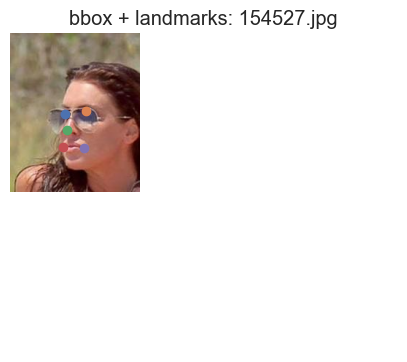

In [7]:

import os
import cv2
import matplotlib.pyplot as plt

# 这里用你真实的图片目录
IMG_DIR = IMG_DIR  # 如果上面有定义，就沿用；没有就写成 "img_align_celeba"

# 随机挑一张图
sample = full_df.sample(1, random_state=0).iloc[0]
img_path = os.path.join(IMG_DIR, sample["image_id"])
print("示例图片：", img_path)

# 读取图像
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(img)

# 画 bbox（列名按你现在的 CSV）
x, y, w, h = sample[["x_1", "y_1", "width", "height"]]
plt.gca().add_patch(
    plt.Rectangle((x, y), w, h, fill=False, linewidth=2)
)

# 画五官关键点
for lx, ly in [
    ("lefteye_x", "lefteye_y"),
    ("righteye_x", "righteye_y"),
    ("nose_x", "nose_y"),
    ("leftmouth_x", "leftmouth_y"),
    ("rightmouth_x", "rightmouth_y"),
]:
    plt.scatter(sample[lx], sample[ly])

plt.axis("off")
plt.title(f"bbox + landmarks: {sample['image_id']}")
plt.show()


各属性正例比例：
Young          0.773617
Smiling        0.482080
Male           0.416754
Eyeglasses     0.065119
Wearing_Hat    0.048460
dtype: float64


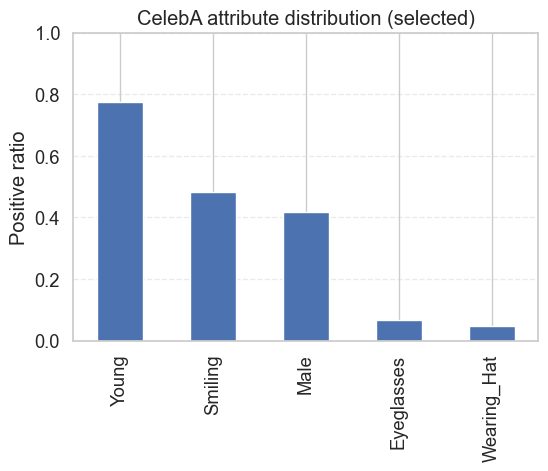

In [8]:
import matplotlib.pyplot as plt

# 随便挑一些有代表性的属性
attr_cols = ["Male", "Smiling", "Young", "Wearing_Hat", "Eyeglasses"]

# CelebA 属性是 -1/1，把它变成 0/1
attr_bin = full_df[attr_cols].replace({-1: 0, 1: 1})

pos_rates = attr_bin.mean().sort_values(ascending=False)
print("各属性正例比例：")
print(pos_rates)

plt.figure(figsize=(6, 4))
pos_rates.plot(kind="bar")
plt.ylabel("Positive ratio")
plt.title("CelebA attribute distribution (selected)")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


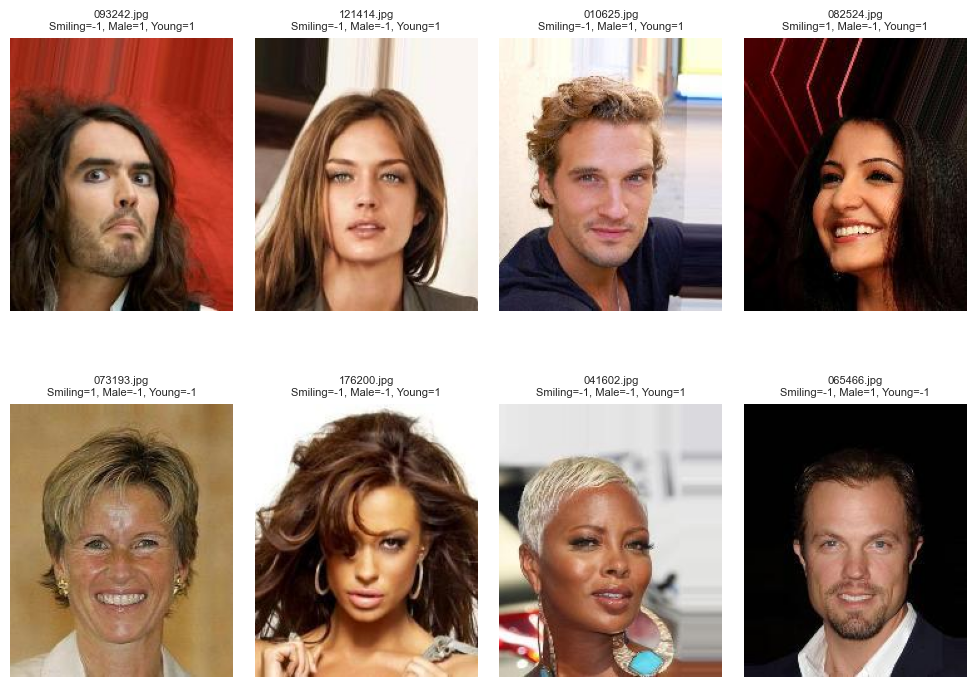

In [9]:
import cv2
from pathlib import Path

from pathlib import Path

IMG_DIR = Path("../archive/img_align_celeba")
  # 用你现在实际用的那个

samples = full_df.sample(8, random_state=42)
show_attrs = ["Smiling", "Male", "Young"]  # 展示在标题里

plt.figure(figsize=(10, 8))
for i, (_, row) in enumerate(samples.iterrows()):
    img_path = IMG_DIR / row["image_id"]
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")

    title = row["image_id"] + "\n" + ", ".join(
        [f"{col}={row[col]}" for col in show_attrs]
    )
    plt.title(title, fontsize=8)

plt.tight_layout()
plt.show()



### 3. 图像几何变换与对齐（Notebook）

- **目的**：做人脸对齐/裁剪/缩放，兼顾数据增强。
- **实现内容**：
  - 根据 bbox 裁剪人脸区域。
  - 根据两眼关键点估算旋转，做仿射对齐（旋正）。
  - 统一缩放到固定尺寸（如 128×128 或 224×224）。
  - 做若干几何增强示例：旋转、水平翻转等。
- **知识点**：仿射变换、插值、数据增强对模型的作用。
- **主要库**：`cv2.getRotationMatrix2D, cv2.warpAffine, cv2.resize, cv2.flip`。
### 4. 图像滤波与去噪（Notebook）

In [10]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# 如果上面已经定义过 IMG_DIR，这里可以注释掉
# IMG_DIR = Path("../data/archive/img_align_celeba")

def load_image(row):
    """根据 full_df 的一行记录读取原始图像(BGR)"""
    img_path = IMG_DIR / row["image_id"]
    img = cv2.imread(str(img_path))
    if img is None:
        raise ValueError(f"图像读取失败: {img_path}")
    return img


def show_rgb(img, title=None, ax=None):
    """安全显示 BGR 图像"""
    if ax is None:
        plt.figure(figsize=(4, 4))
        ax = plt.gca()
    if img is None or img.size == 0:
        ax.text(0.5, 0.5, "空图像", ha="center", va="center")
        ax.axis("off")
        if title:
            ax.set_title(title)
        return ax
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis("off")
    if title:
        ax.set_title(title)
    return ax


# 让中文标题不报错（可选）
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False


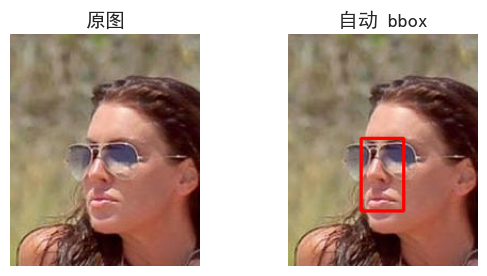

In [11]:

def compute_bbox_from_landmarks(row, img_shape, expand_ratio=0.3):
    """
    用 5 个关键点生成一个人脸 bbox，并适当扩边
    expand_ratio: 在关键点包围盒基础上再放大一点
    """
    h, w = img_shape[:2]

    xs = np.array([
        row["lefteye_x"],
        row["righteye_x"],
        row["nose_x"],
        row["leftmouth_x"],
        row["rightmouth_x"],
    ], dtype=np.float32)

    ys = np.array([
        row["lefteye_y"],
        row["righteye_y"],
        row["nose_y"],
        row["leftmouth_y"],
        row["rightmouth_y"],
    ], dtype=np.float32)

    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    cx = (x_min + x_max) / 2
    cy = (y_min + y_max) / 2
    bw = (x_max - x_min) * (1 + expand_ratio)
    bh = (y_max - y_min) * (1 + expand_ratio * 1.2)  # 竖直方向多放一点

    x1 = int(np.clip(cx - bw / 2, 0, w - 1))
    y1 = int(np.clip(cy - bh / 2, 0, h - 1))
    x2 = int(np.clip(cx + bw / 2, x1 + 1, w))
    y2 = int(np.clip(cy + bh / 2, y1 + 1, h))

    return x1, y1, x2, y2


def crop_face_auto(img, row, expand_ratio=0.3):
    """先根据关键点算 bbox，再裁剪人脸"""
    x1, y1, x2, y2 = compute_bbox_from_landmarks(row, img.shape, expand_ratio)
    face = img[y1:y2, x1:x2].copy()
    return face, (x1, y1, x2, y2)


# 测试：原图 + 自动 bbox 裁剪
sample = full_df.sample(1, random_state=0).iloc[0]
img_raw = load_image(sample)
face_crop, (x1, y1, x2, y2) = crop_face_auto(img_raw, sample, expand_ratio=0.3)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
show_rgb(img_raw, "原图", ax=axes[0])

# 在原图上画出自动 bbox
img_box = img_raw.copy()
cv2.rectangle(img_box, (x1, y1), (x2, y2), (0, 0, 255), 2)
show_rgb(img_box, "自动 bbox", ax=axes[1])

plt.tight_layout()
plt.show()


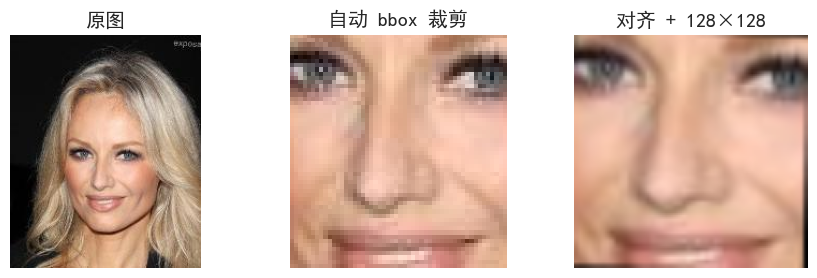

In [12]:

def align_face_by_eyes(img, row, output_size=(128, 128), expand_ratio=0.3):
    """
    1. 用关键点自动生成 bbox 并裁剪
    2. 根据双眼连线旋转对齐
    3. resize 到统一尺寸
    """
    face, (x1, y1, x2, y2) = crop_face_auto(img, row, expand_ratio)
    fh, fw = face.shape[:2]

    # 裁剪后关键点坐标（相对 face）
    lx = row["lefteye_x"] - x1
    ly = row["lefteye_y"] - y1
    rx = row["righteye_x"] - x1
    ry = row["righteye_y"] - y1

    # 计算旋转角度
    dy = ry - ly
    dx = rx - lx
    angle = np.degrees(np.arctan2(dy, dx))
    center = ((lx + rx) / 2.0, (ly + ry) / 2.0)

    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    face_aligned = cv2.warpAffine(face, M, (fw, fh), flags=cv2.INTER_LINEAR)

    face_resized = cv2.resize(face_aligned, output_size, interpolation=cv2.INTER_LINEAR)
    return face_resized


# 看一下效果：原图 -> bbox 裁剪 -> 对齐 + 128×128
sample = full_df.sample(1, random_state=1).iloc[0]
img_raw = load_image(sample)
face_crop, _ = crop_face_auto(img_raw, sample, expand_ratio=0.3)
face_aligned = align_face_by_eyes(img_raw, sample, output_size=(128, 128))

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
show_rgb(img_raw, "原图", ax=axes[0])
show_rgb(face_crop, "自动 bbox 裁剪", ax=axes[1])
show_rgb(face_aligned, "对齐 + 128×128", ax=axes[2])
plt.tight_layout()
plt.show()


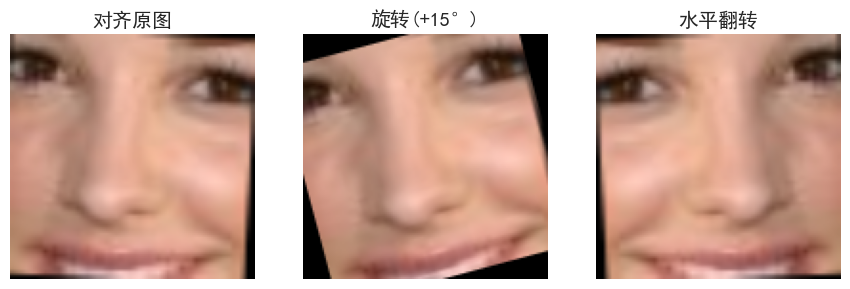

In [13]:

def augment_geometric(img, angle=15):
    """
    对齐后人脸做几何增强：
    - 小角度旋转
    - 水平翻转
    """
    h, w = img.shape[:2]
    center = (w / 2, h / 2)

    M_rot = cv2.getRotationMatrix2D(center, angle, 1.0)
    img_rot = cv2.warpAffine(img, M_rot, (w, h), flags=cv2.INTER_LINEAR)

    img_flip = cv2.flip(img, 1)

    return img_rot, img_flip


sample = full_df.sample(1, random_state=2).iloc[0]
img_raw = load_image(sample)
face_aligned = align_face_by_eyes(img_raw, sample, output_size=(128, 128))
rot_img, flip_img = augment_geometric(face_aligned, angle=15)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
show_rgb(face_aligned, "对齐原图", ax=axes[0])
show_rgb(rot_img, "旋转(+15°)", ax=axes[1])
show_rgb(flip_img, "水平翻转", ax=axes[2])
plt.tight_layout()
plt.show()


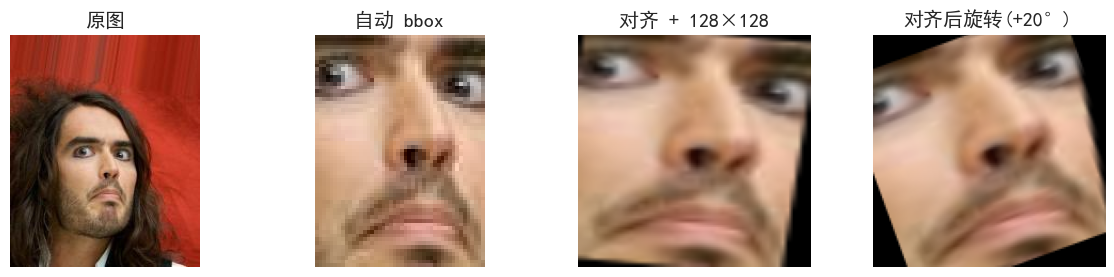

In [14]:

sample = full_df.sample(1, random_state=42).iloc[0]
img_raw = load_image(sample)
face_crop, _ = crop_face_auto(img_raw, sample, expand_ratio=0.3)
face_aligned = align_face_by_eyes(img_raw, sample, output_size=(128, 128))
rot_img, flip_img = augment_geometric(face_aligned, angle=20)

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
show_rgb(img_raw, "原图", ax=axes[0])
show_rgb(face_crop, "自动 bbox", ax=axes[1])
show_rgb(face_aligned, "对齐 + 128×128", ax=axes[2])
show_rgb(rot_img, "对齐后旋转(+20°)", ax=axes[3])
plt.tight_layout()
plt.show()


- **目的**：演示空域滤波：降噪 + 锐化。
- **实现内容**：
  - 高斯滤波 / 均值滤波 / 中值滤波对比。
  - 拉普拉斯或自定义卷积核做锐化。
  - 展示“原图 vs 模糊 vs 锐化”对比。
- **知识点**：卷积、低通/高通滤波，噪声-细节的权衡。
- **主要库**：`cv2.GaussianBlur, cv2.medianBlur, cv2.filter2D`。

---

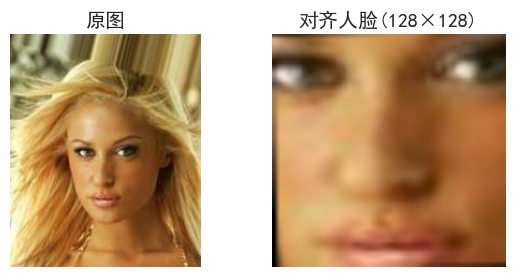

In [15]:

# 随机挑一张样本
sample = full_df.sample(1, random_state=123).iloc[0]

# 原图 + 对齐人脸
img_raw = load_image(sample)
face_aligned = align_face_by_eyes(img_raw, sample, output_size=(128, 128))

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
show_rgb(img_raw, "原图", ax=axes[0])
show_rgb(face_aligned, "对齐人脸(128×128)", ax=axes[1])
plt.tight_layout()
plt.show()


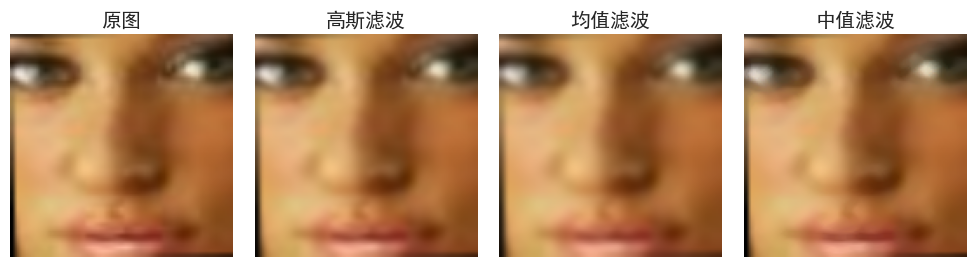

In [16]:

# 高斯滤波：平滑 + 保留一定结构
gauss = cv2.GaussianBlur(face_aligned, ksize=(5, 5), sigmaX=1.0)

# 均值滤波（box filter）：模糊更狠，边缘更糊
mean = cv2.blur(face_aligned, ksize=(5, 5))

# 中值滤波：去椒盐噪声对边缘更友好
median = cv2.medianBlur(face_aligned, ksize=5)

fig, axes = plt.subplots(1, 4, figsize=(10, 3))
show_rgb(face_aligned, "原图", ax=axes[0])
show_rgb(gauss, "高斯滤波", ax=axes[1])
show_rgb(mean, "均值滤波", ax=axes[2])
show_rgb(median, "中值滤波", ax=axes[3])
plt.tight_layout()
plt.show()


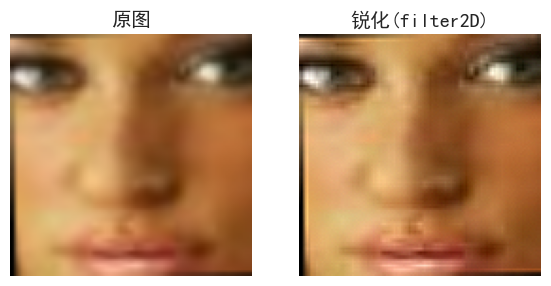

In [17]:

# 经典锐化卷积核（拉普拉斯风格）
sharp_kernel = np.array([[0, -1, 0],
                         [-1, 5, -1],
                         [0, -1, 0]], dtype=np.float32)

sharp = cv2.filter2D(face_aligned, ddepth=-1, kernel=sharp_kernel)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
show_rgb(face_aligned, "原图", ax=axes[0])
show_rgb(sharp, "锐化(filter2D)", ax=axes[1])
plt.tight_layout()
plt.show()


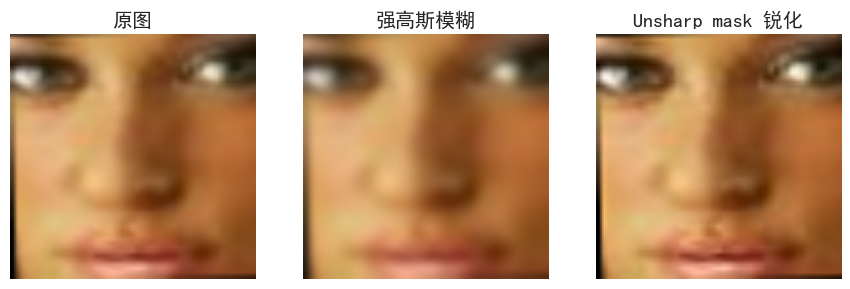

In [18]:

# 先做一个较强的高斯模糊
blur_strong = cv2.GaussianBlur(face_aligned, (0, 0), sigmaX=2.0)

# unsharp mask：原图 - 模糊图的一部分
# 1.5 * 原图 - 0.5 * 模糊图
unsharp = cv2.addWeighted(face_aligned, 1.5, blur_strong, -0.5, 0)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
show_rgb(face_aligned, "原图", ax=axes[0])
show_rgb(blur_strong, "强高斯模糊", ax=axes[1])
show_rgb(unsharp, "Unsharp mask 锐化", ax=axes[2])
plt.tight_layout()
plt.show()


- **目的**：演示空域滤波：降噪 + 锐化。
- **实现内容**：
  - 高斯滤波 / 均值滤波 / 中值滤波对比。
  - 拉普拉斯或自定义卷积核做锐化。
  - 展示“原图 vs 模糊 vs 锐化”对比。
- **知识点**：卷积、低通/高通滤波，噪声-细节的权衡。
- **主要库**：`cv2.GaussianBlur, cv2.medianBlur, cv2.filter2D`。

---
### 5. 直方图处理与图像增强（Notebook）
- **目的**：用直方图均衡化改善对比度，减轻光照差异。
- **实现内容**：
  - 灰度图直方图均衡化。
  - 彩色图：只对亮度通道做 HE 或 CLAHE。
  - 绘制均衡前后直方图和图像效果。
- **知识点**：灰度变换、CDF、全局 vs 自适应均衡。
- **主要库**：`cv2.equalizeHist, cv2.createCLAHE, skimage.exposure`。
---

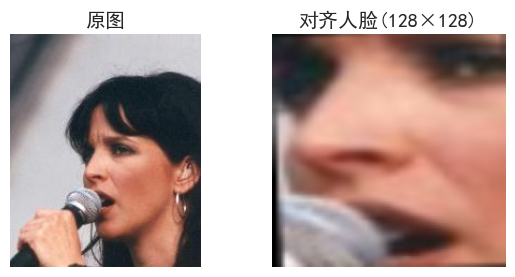

In [19]:

from skimage import exposure  # 后面可选用一下

sample = full_df.sample(1, random_state=2025).iloc[0]
img_raw = load_image(sample)
face = align_face_by_eyes(img_raw, sample, output_size=(128, 128))

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
show_rgb(img_raw, "原图", ax=ax[0])
show_rgb(face, "对齐人脸(128×128)", ax=ax[1])
plt.tight_layout()
plt.show()


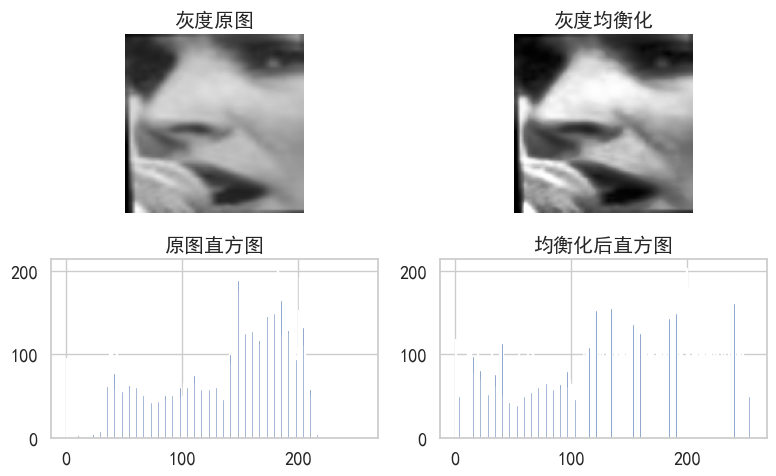

In [20]:

# 转灰度
face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

# OpenCV 全局直方图均衡化
face_gray_he = cv2.equalizeHist(face_gray)

# 绘制图像 + 直方图
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

# 原灰度图
axes[0, 0].imshow(face_gray, cmap="gray")
axes[0, 0].set_title("灰度原图")
axes[0, 0].axis("off")

# 均衡化后
axes[0, 1].imshow(face_gray_he, cmap="gray")
axes[0, 1].set_title("灰度均衡化")
axes[0, 1].axis("off")

# 原图灰度直方图
axes[1, 0].hist(face_gray.ravel(), bins=256, range=(0, 256))
axes[1, 0].set_title("原图直方图")

# 均衡化后直方图
axes[1, 1].hist(face_gray_he.ravel(), bins=256, range=(0, 256))
axes[1, 1].set_title("均衡化后直方图")

plt.tight_layout()
plt.show()


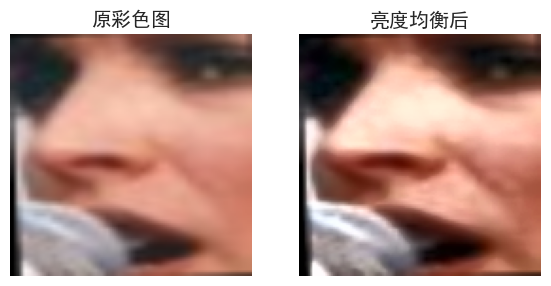

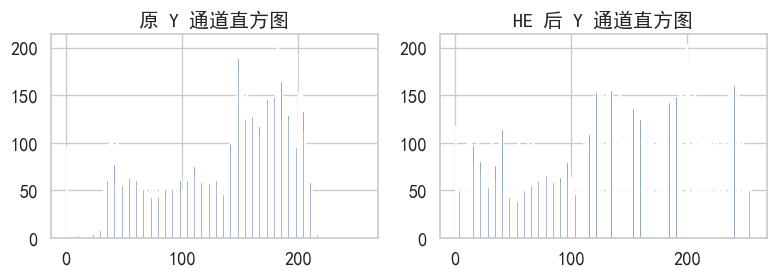

In [21]:

# BGR -> YCrCb
ycrcb = cv2.cvtColor(face, cv2.COLOR_BGR2YCrCb)
Y, Cr, Cb = cv2.split(ycrcb)

Y_he = cv2.equalizeHist(Y)  # 只对亮度做 HE

ycrcb_he = cv2.merge([Y_he, Cr, Cb])
face_color_he = cv2.cvtColor(ycrcb_he, cv2.COLOR_YCrCb2BGR)

# 对比显示
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
show_rgb(face, "原彩色图", ax=axes[0])
show_rgb(face_color_he, "亮度均衡后", ax=axes[1])
plt.tight_layout()
plt.show()

# 亮度直方图对比
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].hist(Y.ravel(), bins=256, range=(0, 256))
axes[0].set_title("原 Y 通道直方图")
axes[1].hist(Y_he.ravel(), bins=256, range=(0, 256))
axes[1].set_title("HE 后 Y 通道直方图")
plt.tight_layout()
plt.show()


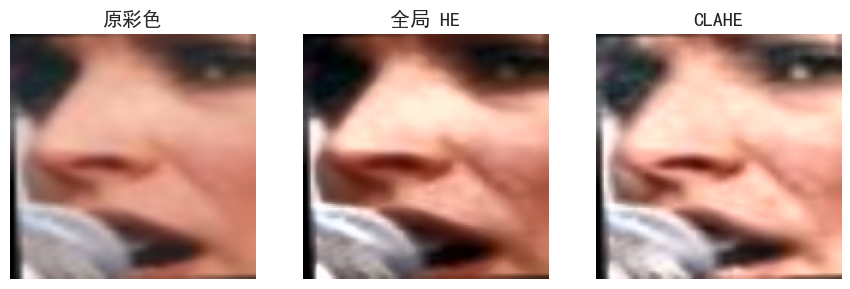

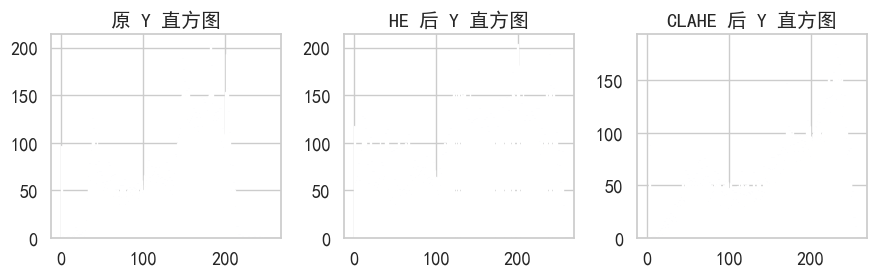

In [22]:

# 创建 CLAHE 对象
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

Y_clahe = clahe.apply(Y)  # 对 Y 通道做 CLAHE

ycrcb_clahe = cv2.merge([Y_clahe, Cr, Cb])
face_color_clahe = cv2.cvtColor(ycrcb_clahe, cv2.COLOR_YCrCb2BGR)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
show_rgb(face, "原彩色", ax=axes[0])
show_rgb(face_color_he, "全局 HE", ax=axes[1])
show_rgb(face_color_clahe, "CLAHE", ax=axes[2])
plt.tight_layout()
plt.show()

# 亮度直方图对比：原 vs HE vs CLAHE
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].hist(Y.ravel(), bins=256, range=(0, 256))
axes[0].set_title("原 Y 直方图")
axes[1].hist(Y_he.ravel(), bins=256, range=(0, 256))
axes[1].set_title("HE 后 Y 直方图")
axes[2].hist(Y_clahe.ravel(), bins=256, range=(0, 256))
axes[2].set_title("CLAHE 后 Y 直方图")
plt.tight_layout()
plt.show()


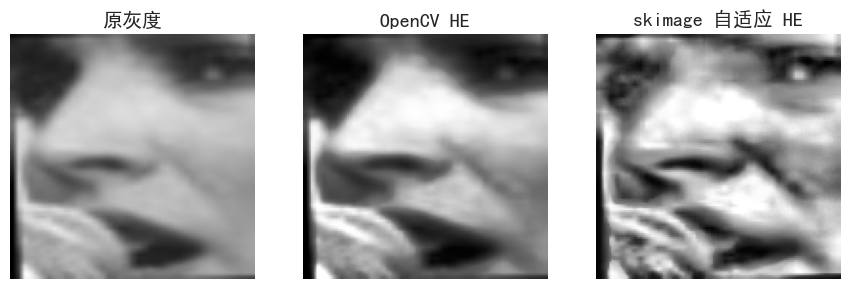

In [23]:

face_gray_float = face_gray / 255.0
face_gray_adapt = exposure.equalize_adapthist(face_gray_float, clip_limit=0.03)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(face_gray, cmap="gray")
axes[0].set_title("原灰度")
axes[0].axis("off")

axes[1].imshow(face_gray_he, cmap="gray")
axes[1].set_title("OpenCV HE")
axes[1].axis("off")

axes[2].imshow(face_gray_adapt, cmap="gray")
axes[2].set_title("skimage 自适应 HE")
axes[2].axis("off")

plt.tight_layout()
plt.show()


### 6. 图像分割与形态学处理（Notebook）
- **目的**：尝试把人脸前景从背景里分出来。
- **实现内容**：
  - Otsu 阈值法生成粗糙的人脸掩膜。
  - 形态学开/闭运算去噪和填洞。
  - 展示：“原图、初始掩膜、形态学后掩膜”。
  - 可选：对某几张图用 K-means 做简易颜色分割。
- **知识点**：阈值分割、腐蚀/膨胀、开闭运算。
- **主要库**：`cv2.threshold, cv2.morphologyEx, skimage.morphology`。
---

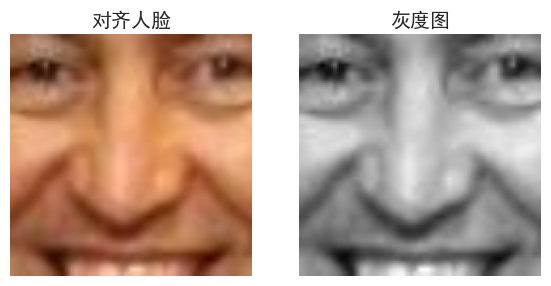

In [24]:

sample = full_df.sample(1, random_state=666).iloc[0]
img_raw = load_image(sample)
face = align_face_by_eyes(img_raw, sample, output_size=(128, 128))

face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
show_rgb(face, "对齐人脸", ax=axes[0])
axes[1].imshow(face_gray, cmap="gray")
axes[1].set_title("灰度图")
axes[1].axis("off")
plt.tight_layout()
plt.show()


Otsu 自动阈值 = 131.0


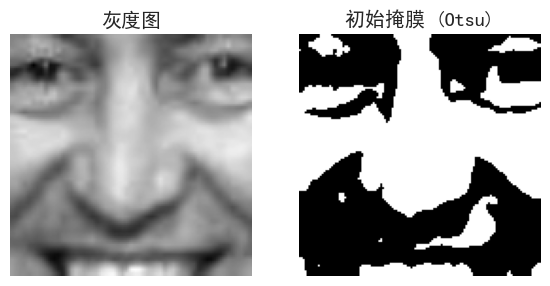

In [25]:

# Otsu 自动阈值：ret 是阈值，mask_raw 是 0/255 二值图
ret, mask_raw = cv2.threshold(
    face_gray, 0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

print("Otsu 自动阈值 =", ret)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(face_gray, cmap="gray")
axes[0].set_title("灰度图")
axes[0].axis("off")

axes[1].imshow(mask_raw, cmap="gray")
axes[1].set_title("初始掩膜 (Otsu)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


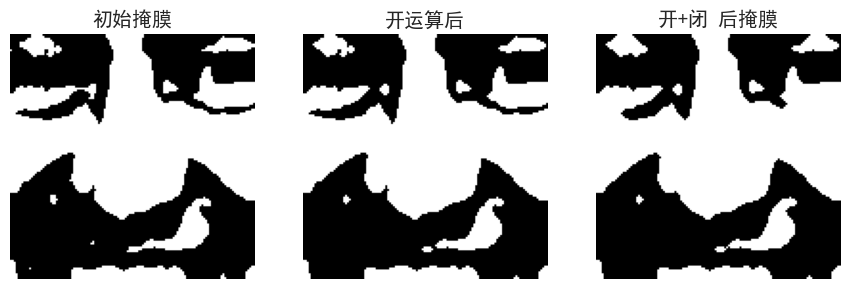

In [26]:

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# 开运算：先腐蚀再膨胀，去掉小白点噪声
mask_open = cv2.morphologyEx(mask_raw, cv2.MORPH_OPEN, kernel, iterations=1)

# 闭运算：先膨胀再腐蚀，填补小黑洞
mask_clean = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, kernel, iterations=2)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(mask_raw, cmap="gray")
axes[0].set_title("初始掩膜")
axes[0].axis("off")

axes[1].imshow(mask_open, cmap="gray")
axes[1].set_title("开运算后")
axes[1].axis("off")

axes[2].imshow(mask_clean, cmap="gray")
axes[2].set_title("开+闭 后掩膜")
axes[2].axis("off")

plt.tight_layout()
plt.show()


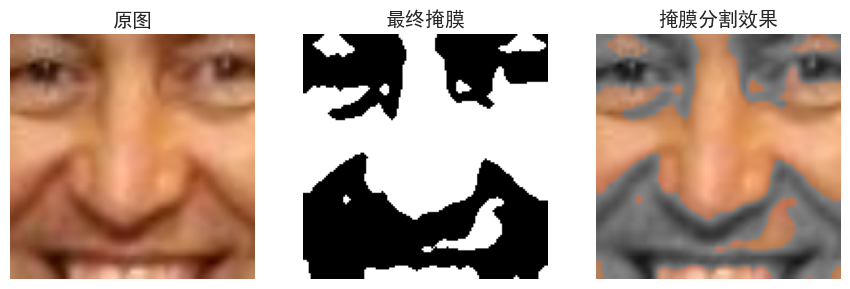

In [27]:

# 把 0/255 掩膜变成 0/1 的三通道
mask_3c = cv2.cvtColor(mask_clean, cv2.COLOR_GRAY2BGR) // 255

# 前景 = face * mask；背景用灰色填充方便对比
foreground = face * mask_3c
background_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
background_gray = cv2.cvtColor(background_gray, cv2.COLOR_GRAY2BGR)
bg_with_hole = background_gray * (1 - mask_3c)
segmented = foreground + bg_with_hole

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
show_rgb(face, "原图", ax=axes[0])
axes[1].imshow(mask_clean, cmap="gray")
axes[1].set_title("最终掩膜")
axes[1].axis("off")
show_rgb(segmented, "掩膜分割效果", ax=axes[2])
plt.tight_layout()
plt.show()


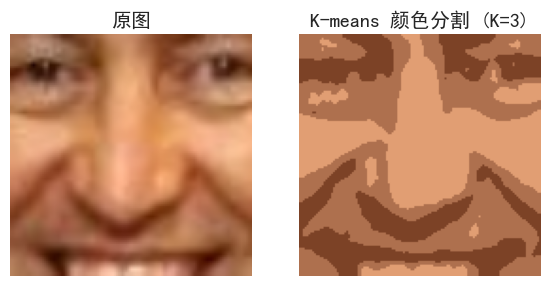

In [28]:

Z = face.reshape((-1, 3)).astype(np.float32)

K = 3
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
ret, labels, centers = cv2.kmeans(
    Z, K, None, criteria, 5, cv2.KMEANS_RANDOM_CENTERS
)

centers = np.uint8(centers)
seg_kmeans = centers[labels.flatten()].reshape(face.shape)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
show_rgb(face, "原图", ax=axes[0])
show_rgb(seg_kmeans, "K-means 颜色分割 (K=3)", ax=axes[1])
plt.tight_layout()
plt.show()


- **目的**：提取轮廓结构（下巴、眼睛、眼镜框等）。
- **实现内容**：
  - 计算 Sobel X/Y、梯度幅值图。
  - Canny 边缘检测。
  - 将边缘叠加到原图上展示。
- **知识点**：一阶/二阶导、Sobel、Canny 各步骤。
- **主要库**：`cv2.Sobel, cv2.Canny, skimage.filters, skimage.feature.canny`。

---

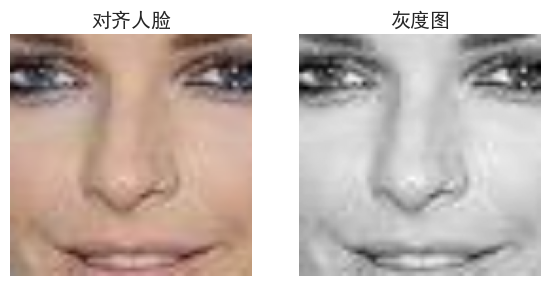

In [29]:

sample = full_df.sample(1, random_state=777).iloc[0]
img_raw = load_image(sample)
face = align_face_by_eyes(img_raw, sample, output_size=(128, 128))
face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
show_rgb(face, "对齐人脸", ax=axes[0])
axes[1].imshow(face_gray, cmap="gray")
axes[1].set_title("灰度图")
axes[1].axis("off")
plt.tight_layout()
plt.show()


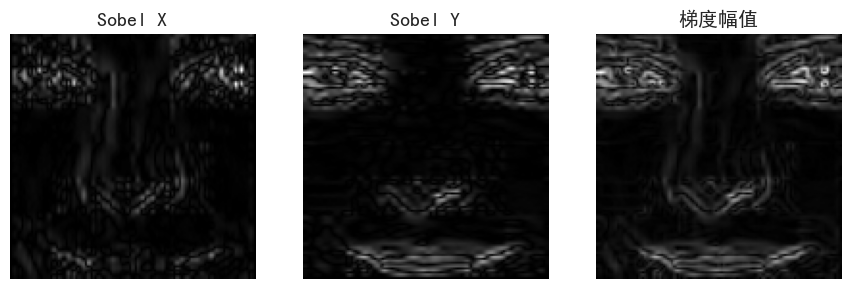

In [30]:

# Sobel X / Y（浮点结果）
sobel_x = cv2.Sobel(face_gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(face_gray, cv2.CV_64F, 0, 1, ksize=3)

# 梯度幅值 = sqrt(sobel_x^2 + sobel_y^2)
grad_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
grad_mag = np.uint8(255 * grad_mag / grad_mag.max())  # 归一化到 0-255

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(np.abs(sobel_x), cmap="gray")
axes[0].set_title("Sobel X");
axes[0].axis("off")
axes[1].imshow(np.abs(sobel_y), cmap="gray")
axes[1].set_title("Sobel Y");
axes[1].axis("off")
axes[2].imshow(grad_mag, cmap="gray")
axes[2].set_title("梯度幅值");
axes[2].axis("off")

plt.tight_layout()
plt.show()


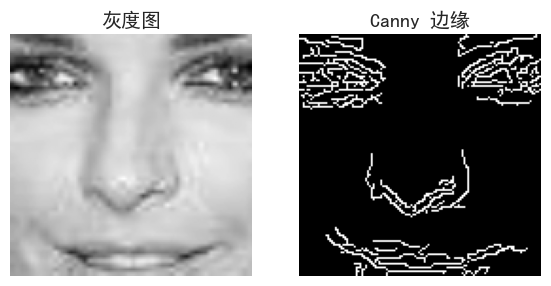

In [31]:

# 一般阈值：低=50, 高=150
edges = cv2.Canny(face_gray, threshold1=50, threshold2=150)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(face_gray, cmap="gray")
axes[0].set_title("灰度图");
axes[0].axis("off")
axes[1].imshow(edges, cmap="gray")
axes[1].set_title("Canny 边缘");
axes[1].axis("off")

plt.tight_layout()
plt.show()


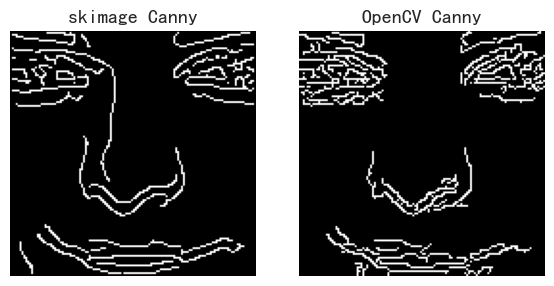

In [32]:

from skimage.feature import canny

edges_ski = canny(face_gray, sigma=1.5)  # skimage 返回 True/False

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(edges_ski, cmap="gray")
axes[0].set_title("skimage Canny");
axes[0].axis("off")

axes[1].imshow(edges, cmap="gray")
axes[1].set_title("OpenCV Canny");
axes[1].axis("off")

plt.tight_layout()
plt.show()


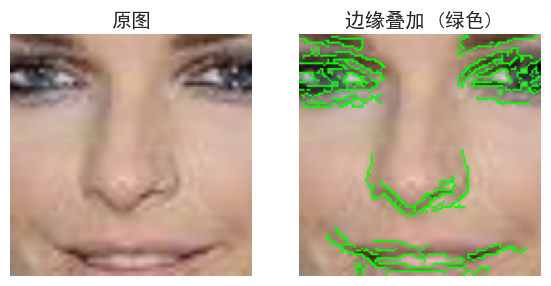

In [33]:

edges_color = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

overlay = face.copy()
overlay[edges > 0] = (0, 255, 0)  # 边缘画成绿色

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
show_rgb(face, "原图", ax=axes[0])
show_rgb(overlay, "边缘叠加 (绿色)", ax=axes[1])
plt.tight_layout()
plt.show()



### 8. 特征提取（Notebook）
- **目的**：把图像变成特征向量，连接到“机器学习世界”。
- **实现内容**：
  - 基于分割掩膜的形状特征：面积、周长等。
  - 纹理特征：LBP / HOG。
  - 角点特征：Harris 角点或 ORB 关键点。
  - 可选：抽几张图用预训练 CNN 提取特征向量（当作对比）。
- **知识点**：形状特征、纹理特征、局部特征点的概念；图像→向量。
- **主要库**：
  - `skimage.feature.local_binary_pattern, skimage.feature.hog`
  - `- `cv2.cornerHarris, cv2.ORB_create` 等。

形状特征：
  面积 (pixels): 13074.0
  周长 (pixels): 770.0731538534164
  面积占比: 0.7979736328125


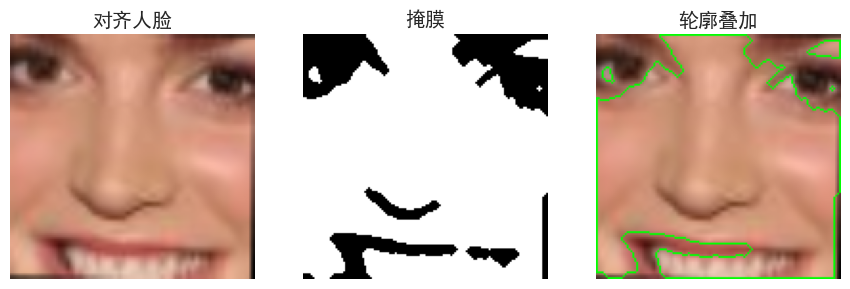

In [34]:

import cv2
import numpy as np
from skimage.feature import local_binary_pattern, hog


def get_face_and_mask(row, size=(128, 128)):
    """对齐人脸 + Otsu 分割 + 开闭运算，返回 face, mask_clean"""
    img_raw = load_image(row)
    face = align_face_by_eyes(img_raw, row, output_size=size)
    gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

    # Otsu 阈值
    _, mask = cv2.threshold(
        gray, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask_clean = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, kernel, iterations=2)
    return face, gray, mask_clean


sample = full_df.sample(1, random_state=8).iloc[0]
face, face_gray, mask_clean = get_face_and_mask(sample)

# 轮廓提取
contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

area = 0.0
perimeter = 0.0
for cnt in contours:
    area += cv2.contourArea(cnt)
    perimeter += cv2.arcLength(cnt, True)

print("形状特征：")
print("  面积 (pixels):", area)
print("  周长 (pixels):", perimeter)
print("  面积占比:", area / (mask_clean.shape[0] * mask_clean.shape[1]))

# 可视化：原图 + 掩膜 + 轮廓
contour_vis = face.copy()
cv2.drawContours(contour_vis, contours, -1, (0, 255, 0), 1)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
show_rgb(face, "对齐人脸", ax=axes[0])
axes[1].imshow(mask_clean, cmap="gray");
axes[1].set_title("掩膜");
axes[1].axis("off")
show_rgb(contour_vis, "轮廓叠加", ax=axes[2])
plt.tight_layout()
plt.show()


LBP 特征维度: (10,)
LBP 特征前 10 维: [0.0032959  0.01580811 0.01751709 0.12115479 0.42071533 0.27331543
 0.05493164 0.03619385 0.03753662 0.01953125]


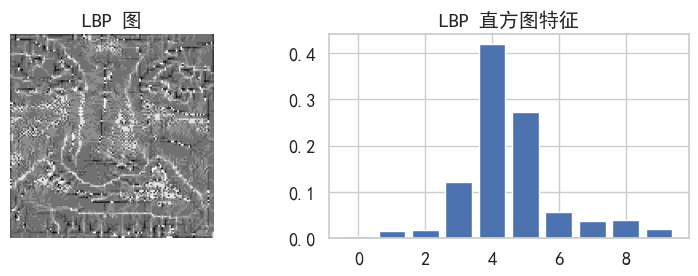

In [35]:

# 使用 LBP（局部二值模式），radius=1, P=8
P = 8
R = 1
lbp = local_binary_pattern(face_gray, P, R, method="uniform")

# LBP 直方图作为特征向量
n_bins = P + 2  # uniform 模式下的理论 bins
hist_lbp, _ = np.histogram(lbp.ravel(),
                           bins=n_bins,
                           range=(0, n_bins),
                           density=True)

print("LBP 特征维度:", hist_lbp.shape)
print("LBP 特征前 10 维:", hist_lbp[:10])

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(lbp, cmap="gray")
axes[0].set_title("LBP 图")
axes[0].axis("off")

axes[1].bar(np.arange(n_bins), hist_lbp)
axes[1].set_title("LBP 直方图特征")
plt.tight_layout()
plt.show()


HOG 特征维度: (8100,)


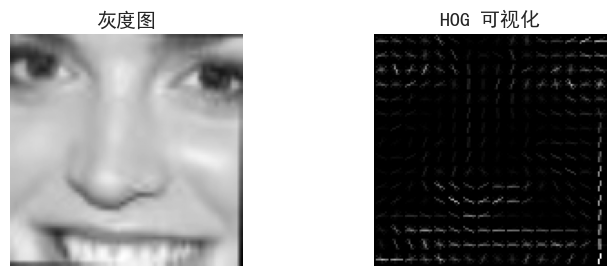

In [36]:

hog_vec, hog_vis = hog(
    face_gray,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    block_norm="L2-Hys"
)

print("HOG 特征维度:", hog_vec.shape)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(face_gray, cmap="gray")
axes[0].set_title("灰度图");
axes[0].axis("off")
axes[1].imshow(hog_vis, cmap="gray")
axes[1].set_title("HOG 可视化");
axes[1].axis("off")
plt.tight_layout()
plt.show()


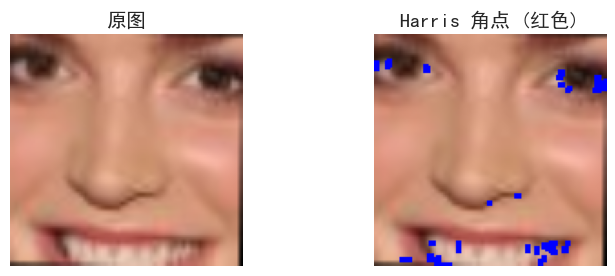

In [37]:

# Harris 角点检测
gray_float = np.float32(face_gray)
harris = cv2.cornerHarris(gray_float, 2, 3, 0.04)
harris = cv2.dilate(harris, None)

# 阈值调高！去噪
th = 0.05  # 可以试 0.05~0.1
corner_vis = face.copy()
corner_vis[harris > th * harris.max()] = [255, 0, 0]
 # 角点涂成红色

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
show_rgb(face, "原图", ax=axes[0])
show_rgb(corner_vis, "Harris 角点 (红色)", ax=axes[1])
plt.tight_layout()
plt.show()


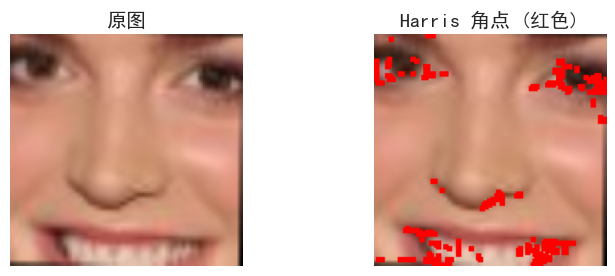

In [38]:

# Harris 角点检测
gray_float = np.float32(face_gray)
harris = cv2.cornerHarris(gray_float, blockSize=2, ksize=3, k=0.04)
harris = cv2.dilate(harris, None)

# 阈值筛选显著角点
corner_vis = face.copy()
corner_vis[harris > 0.01 * harris.max()] = [0, 0, 255]  # 角点涂成红色

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
show_rgb(face, "原图", ax=axes[0])
show_rgb(corner_vis, "Harris 角点 (红色)", ax=axes[1])
plt.tight_layout()
plt.show()


In [39]:

import torch
import torchvision.models as models
import torchvision.transforms as T

# 只加载一次模型
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18.eval()

# 去掉最后的分类层，保留特征
feature_extractor = torch.nn.Sequential(*list(resnet18.children())[:-1])

transform_cnn = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

# face 是 BGR，需要转成 RGB
face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
inp = transform_cnn(face_rgb).unsqueeze(0)  # [1,3,224,224]

with torch.no_grad():
    feat = feature_extractor(inp)  # [1, 512, 1, 1]
feat_vec = feat.view(-1).cpu().numpy()

print("ResNet18 特征维度:", feat_vec.shape)
print("前 10 维:", feat_vec[:10])


ResNet18 特征维度: (512,)
前 10 维: [0.28472248 0.5172567  0.62078977 0.14420177 0.09242302 0.5783052
 0.50492483 0.08665656 0.01826174 0.03948857]


### 9. 深度学习模型构建（Notebook）
- **目的**：做一个简单的人脸属性分类器（例如：性别 / 是否戴眼镜）。
- **实现内容**：
  - 从 `list_attr_celeba.csv` 中选 1–2 个属性作为标签。
  - 定义小型 CNN（或加载轻量级预训练模型并改最后一层）。
  - 打印模型结构（summary）。
- **知识点**：卷积层/池化层/全连接层的基本作用；模型尺寸与显存的关系。
- **主要库**：`torch` 或 `tensorflow.keras`。

In [41]:

class CelebAFaceDataset(Dataset):
    def __init__(self, df, target_attrs, image_size=(128, 128), augment=False):
        self.df = df.reset_index(drop=True)
        self.target_attrs = target_attrs
        self.image_size = image_size

        # 基础变换：转 tensor + 归一化到 [-1,1]
        base_transforms = [
            T.ToTensor(),
            T.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5]),
        ]

        # 训练集可以加一点简单增强（可关）
        if augment:
            self.transform = T.Compose([
                T.RandomHorizontalFlip(p=0.5),
                T.ToTensor(),
                T.Normalize(mean=[0.5, 0.5, 0.5],
                            std=[0.5, 0.5, 0.5]),
            ])
        else:
            self.transform = T.Compose(base_transforms)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # BGR 原图
        img_raw = load_image(row)

        # 对齐 + resize
        face = align_face_by_eyes(img_raw, row, output_size=self.image_size)  # BGR

        # BGR -> RGB -> PIL
        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(face_rgb)

        x = self.transform(img_pil)  # [3,H,W]

        # 取标签，float32 多标签（0/1）
        y_vals = row[self.target_attrs].astype(np.float32).values
        y = torch.from_numpy(y_vals)  # [num_attrs]
        return x, y


IMAGE_SIZE = (128, 128)
train_dataset = CelebAFaceDataset(train_df, target_attrs, IMAGE_SIZE, augment=True)
val_dataset = CelebAFaceDataset(val_df, target_attrs, IMAGE_SIZE, augment=False)

BATCH_SIZE = 256  # 4060 完全扛得住；不够就减到 128
NUM_WORKERS = 4  # 按你 CPU 情况调整

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_dataset), len(val_dataset)


(162770, 19867)